# Анализ продаж компьютерных игр

В проекте рассмотрим исторические данные из открытых источников о продажах компьютерных игр:
- определим, как оценки пользователей, оценки критиков влияют на их продажи;
- попробуем выяснить тенденции: продажи игр на каких платформах растут, какой средний период популярности платформы и как часто старые платформы сменяются новыми;
- найдем самые популярные платформы, жанры и возрастыне рейтинги по трем регионам: Северная Америка, Европа и Япония;
- проверим: правда ли, что средние пользовательские рейтинг платформ Xbox One и PC равны, а средние рейтинги жанров Action и Sports отличаются.

Все это поможет сделать прогноз потенциально популярных продуктов в будущем и спланировать рекламные кампании.

## Загрузка необходимых библиотек и исходных данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
df = pd.read_csv('games.csv')

Посмотрим первые пять строк из нашего датафрейма

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


## Предобработка данных

**Переименование столбцов**

Приведем названия столбцов к змеиному регистру. Данные о продажах выражены в млн проданных копий - отразим это в названии столбцов.

In [4]:
def columns_renaming(data):
  cols = list(data.columns)
  for col in cols:
    if 'sales' in col.split('_'):
        data = data.rename(columns={col: col.lower()+'_(millions)'})
    else:
        data = data.rename(columns={col: col.lower()})
  return data

df = columns_renaming(df)

**Общая информация по датафрейму**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    16713 non-null  object 
 1   platform                16715 non-null  object 
 2   year_of_release         16446 non-null  float64
 3   genre                   16713 non-null  object 
 4   na_sales_(millions)     16715 non-null  float64
 5   eu_sales_(millions)     16715 non-null  float64
 6   jp_sales_(millions)     16715 non-null  float64
 7   other_sales_(millions)  16715 non-null  float64
 8   critic_score            8137 non-null   float64
 9   user_score              10014 non-null  object 
 10  rating                  9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


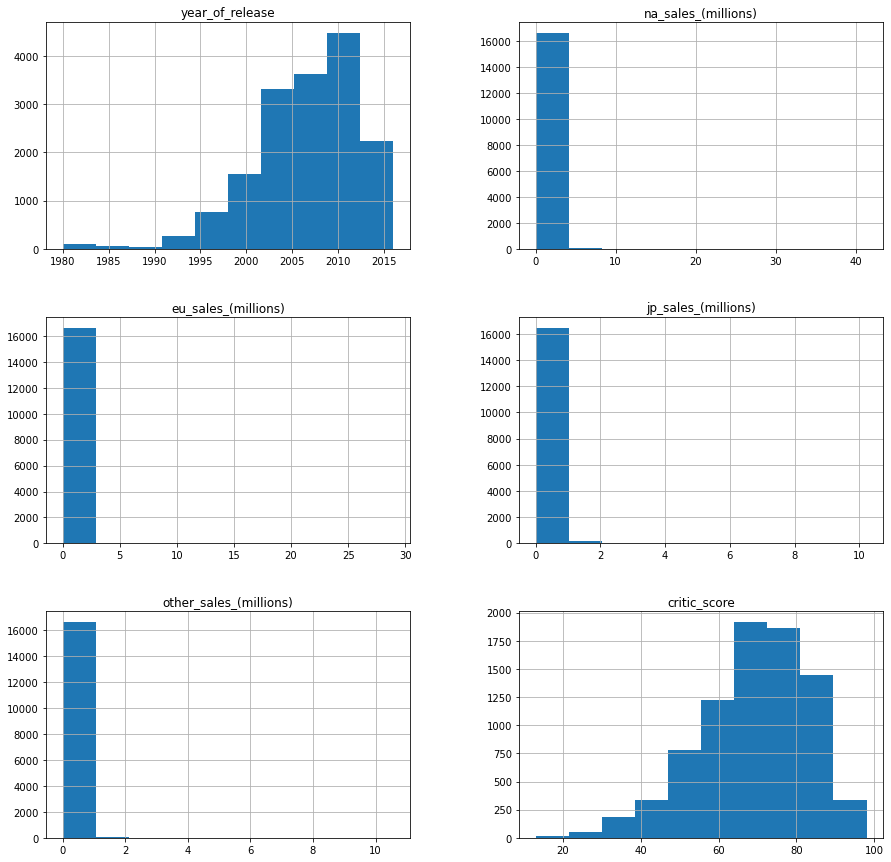

In [6]:
df.hist(figsize=(15,15));

- всего в датафрейме 16715 записей;
- в 6 столбцах из 11 есть пропуски:
    - столбцах name и year_of_release их всего по 2; 
    - в столбцах critic_score, user_score и rating пропущено по 50-60 % значений;
- имеет смысл сделать преобразование типов:
    - year_of_release преобразовать к int, так как данные есть только по году, а не по полной дате, поэтому этот столбец можно выразить целочисленно;
    - critic_score преобразовать к int, так как в этом столбце встречаются только целочисленные значения;
    - user_score преобразовать к float, так как в этом столбце встречаются дробные значения и нам нужна возможность осуществлять математические операции над ними.
- в столбцах с количеством проданных копий есть выбивающиеся значения. Но они не настолько велики, чтобы считать их явными выбросами, не соответсвующими реальности. Возможно, именно на основе этих записей будут важные выводы.  

**Преобразование типов**

In [7]:
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['critic_score'] = df['critic_score'].astype('Int64')
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    16713 non-null  object 
 1   platform                16715 non-null  object 
 2   year_of_release         16446 non-null  Int64  
 3   genre                   16713 non-null  object 
 4   na_sales_(millions)     16715 non-null  float64
 5   eu_sales_(millions)     16715 non-null  float64
 6   jp_sales_(millions)     16715 non-null  float64
 7   other_sales_(millions)  16715 non-null  float64
 8   critic_score            8137 non-null   Int64  
 9   user_score              7590 non-null   float64
 10  rating                  9949 non-null   object 
dtypes: Int64(2), float64(5), object(4)
memory usage: 1.4+ MB


Количество пропусков в столбце user_score по сравнению с исходными данными увеличилось на 2424.

Это произошло потому, что в исходных данных в этом столбце было 2424 значения "tbd". 

**tbd** - to be determined. Эта аббревиатура обычно описывает то, что еще не определено или не решено. (*в реальной ситуации хорошо было бы поинтересоваться у разработчиков, что конкретно в нашем случае обозначают такие "заглушки"*)

При преобразовании значений в столбце к типу float записи "tbd" были заменены на NaN.

Несмотря на то, что на первый взгляд кажется, что в процессе преобразования типов мы что-то потеряли, фактически целостность исходных данных сохранилась. 

**Обработка пропусков**

Посмотрим на процент пропущенных значений в каждом столбце

In [8]:
df.isna().mean()

name                      0.000120
platform                  0.000000
year_of_release           0.016093
genre                     0.000120
na_sales_(millions)       0.000000
eu_sales_(millions)       0.000000
jp_sales_(millions)       0.000000
other_sales_(millions)    0.000000
critic_score              0.513192
user_score                0.545917
rating                    0.404786
dtype: float64

Процент пропущенных значений в столбцах name и genre совпадают. Возможно, пропуски в обоих столбцах в одних и тех же записях. Посмотрим

In [9]:
df[df['name'].isna() | df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales_(millions),eu_sales_(millions),jp_sales_(millions),other_sales_(millions),critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Предположение подтвердилось. Большой ценности информация, содержащаяся в этих строках, для нас не представляет (почти во всех столбцах значения пропущены), поэтому удалим их.

In [10]:
df = df[df['name'].notna()]

Почему заполнять пропуски в столбцах critic_score, user_score, rating и year_of_release не самая лучшая идея:
- если заполним средним или медианой по какой бы то ни было группе, существенно исказим исходные данные, заменив реальные данные выдуманными;
- если заполним нулями - сдвинем и среднее, и медиану;
- если заполним строковыми значениями - то это приведет к обратному преобразованию типов к object, что исключает возможность корректного проведения математических операций со значениями в столбцах.

Поэтому для обработки пропусков в столбцах critic_score, user_score добавим в наш датафрейм дополнительные столбцы, в которых будут храниться "флаги", показывающие пропуски в перечисленных столбцах.

In [11]:
for col in ['critic_score', 'user_score']:
    df['no_'+col] = df[col].isna()

Таким  образом, мы сохранили целостность исходных данных, но пропуски в данных остались. Однако теперь мы знаем, где они находятся, благодаря новым столбцам-флагам.

Пропуски в данных могут быть обусловлены некорректной работой системы сбора и хранения данных либо невнимательностью компаний-разрабочиков при заполнении "карточек" своих игр.

**Обработка дубликатов**

In [12]:
df.duplicated().sum()

0

Явных дубликатов нет.

**Подсчёт суммарных продаж во всех регионах**

Добавим столбец с суммой продаж по всем регионам.

In [13]:
df['total_sales_(millions)'] = df['na_sales_(millions)'] \
+ df['eu_sales_(millions)'] + df['jp_sales_(millions)'] + df['other_sales_(millions)']

Посмотрим на строки, где год выпуска пропущен:

In [14]:
df[df['year_of_release'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 183 to 16522
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    269 non-null    object 
 1   platform                269 non-null    object 
 2   year_of_release         0 non-null      Int64  
 3   genre                   269 non-null    object 
 4   na_sales_(millions)     269 non-null    float64
 5   eu_sales_(millions)     269 non-null    float64
 6   jp_sales_(millions)     269 non-null    float64
 7   other_sales_(millions)  269 non-null    float64
 8   critic_score            154 non-null    Int64  
 9   user_score              127 non-null    float64
 10  rating                  181 non-null    object 
 11  no_critic_score         269 non-null    bool   
 12  no_user_score           269 non-null    bool   
 13  total_sales_(millions)  269 non-null    float64
dtypes: Int64(2), bool(2), float64(6), obje

Больше, чем в половине записей, где отсутствует год  выпуска, отсутствуют еще и оценки пользователей, оценки критиков и возрастные рейтинги. Поэтому удалим записи с пропущенным годом выпуска:

In [15]:
df = df[df['year_of_release'].notna()]

Возрастной рейтинг ESRB определяется для игр, выпущенных в Канаде и США. Следовательно, отсутствие рейтинга может говорить просто о другой стране выпуска игры. Заменим пропуски на заглушку ""no_rating". 

In [16]:
df['rating'] = df['rating'].fillna('no_rating')

## Исследовательский анализ данных

**Количество игр, выпущенных в разные годы**

In [17]:
(df.groupby('year_of_release')['name']\
    .agg({'count'})\
    .reset_index()\
    .sort_values(by='count', ascending=False)) 

,year_of_release,count
28,2008,1427
29,2009,1426
30,2010,1255
27,2007,1197
31,2011,1136
26,2006,1006
25,2005,939
22,2002,829
23,2003,775
24,2004,762


Посмотрим, как это распределение выглядит на графике 

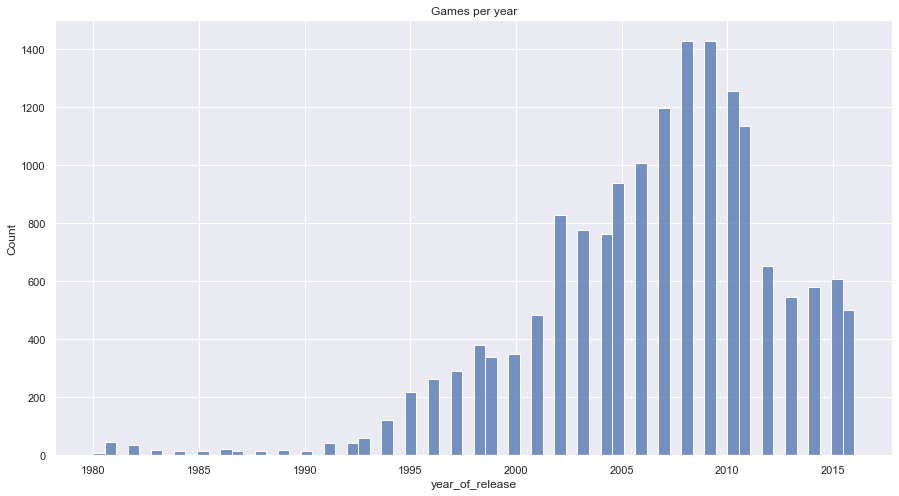

In [18]:
# установка размеров графика
sns.set(rc={'figure.figsize':(15,8)})

# построение графика
sns.histplot(data = df, x='year_of_release').set_title('Games per year');

Рост количества выпускаемых игр за год начался в 90-х годах.

Пик количества выпущенных игр приходится на 2008-2009 годы.

В 2012 году произошел достаточно резкий спад количества выпущенных за год игр.

В 1980-х годах, по-видимому, индустрия игр была развита слабо, поэтому данные за этот период, скорее всего, можно не учитывать при анализе тенденций и взаимозависимостей в нынешних условиях.

**Платформы с наибольшими суммарными продажами**

Выберем 10 платформ с наибольшими суммарными продажами

In [19]:
t = df.groupby('platform')['total_sales_(millions)']\
            .agg({'sum'})\
            .sort_values(by='sum', ascending=False)\
            .reset_index()[:10]
t

,platform,sum
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Построим графики суммарных продаж за год для каждой платформы  

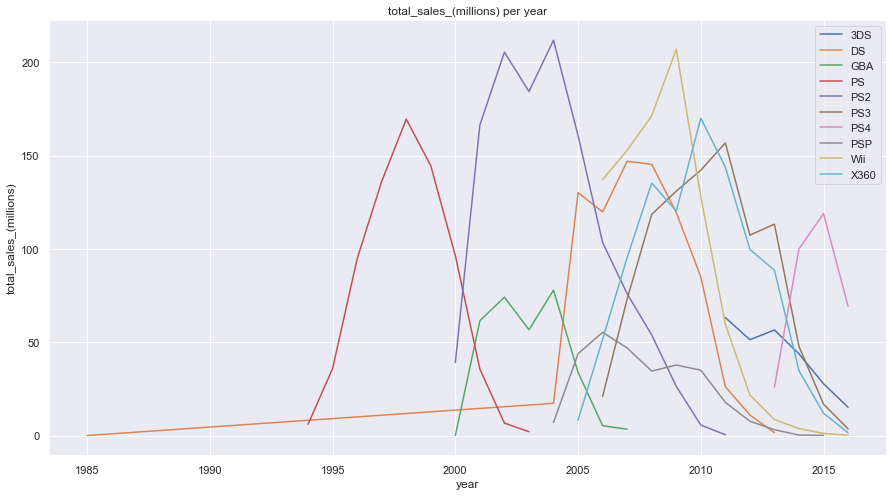

In [20]:
top_sales_platforms = df[(df['platform'].isin(t['platform']))]
top_sales_platforms = (top_sales_platforms\
                       .groupby(['platform', 'year_of_release'])['total_sales_(millions)']\
                       .agg({'sum'}).reset_index())

for platform in top_sales_platforms['platform'].unique():
    t = top_sales_platforms[top_sales_platforms['platform'] == platform]
    sns.lineplot(data=t, x='year_of_release', y='sum', label=platform)

plt.legend(loc='best')
plt.title('total_sales_(millions) per year')
plt.xlabel('year')
plt.ylabel('total_sales_(millions)')
plt.show()


Посмотрим, много ли игр было на платформе DS до 2000 года:

In [21]:
df[(df['platform'] == 'DS') & (df['year_of_release'] < 2000)]

,name,platform,year_of_release,genre,na_sales_(millions),eu_sales_(millions),jp_sales_(millions),other_sales_(millions),critic_score,user_score,rating,no_critic_score,no_user_score,total_sales_(millions)
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,<NA>,NaN,no_rating,True,True,0.02


Всего одна такая игра. Еще и с нулевыми продажами в Европе и Северной Америке, с нулевыми оценками пользователей и критиков. Скорее всего, ошибка - удалим эту запись

In [22]:
df = df.drop(df[(df['platform'] == 'DS') & (df['year_of_release'] < 2000)].index)

По графикам видно, что в среднем жизненный цикл платформы составляет 5-10 лет: за это время продажи успевают вырасти до пиковых значений и вернуться к начальным.

Также наблюдается периодичность: каждые 5-8 лет старые платформы сменяются новыми.

**Выбор потенциально прибыльных платформ**

Так как предполагаемый период популярности платформы составляет 5-10 лет, а старые платформы обычно сменяются новыми каждые 5-8 лет, для прогнозирования потенциально прибыльных платформ в 2017 году представляется логичным рассмотреть: какие тенденции в продажах у каждой платформы наблюдались в 2013-2016 годах.

In [23]:
df_2013_2016 = df[df['year_of_release'].between(2013,2016)]

Сгруппируем данные в полученной выборке по платформе и году и посчитаем суммарное количество продаж.

In [24]:
df_2013_2016 = (df_2013_2016\
 .groupby(['platform', 'year_of_release'])['total_sales_(millions)']\
 .agg({'sum'}).reset_index())

Для каждой платформы в полученной сводной таблице построим графики зависимости суммарного количества продаж от года.

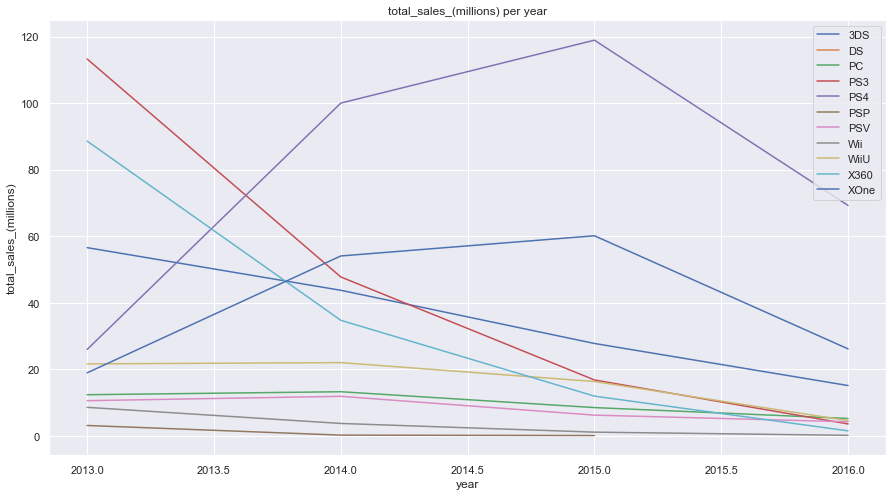

In [25]:
for platform in df_2013_2016['platform'].unique():
    t = df_2013_2016[df_2013_2016['platform'] == platform]
    sns.lineplot(data=t, x='year_of_release', y='sum', label=platform)

plt.legend(loc='best')
plt.title('total_sales_(millions) per year')
plt.xlabel('year')
plt.ylabel('total_sales_(millions)')
plt.show()

По графикам видно, что популярность почти всех платформ за 2013-2016 снижалась. 

Выделяются две платформы: PS4 и XOne. Обе появились в 2013 и до 2015 года их продажи росли. Но в 2016 году наблюдается спад продаж. Однако здесь вспомним, что за 2016 год у нас данные неполные - именно поэтому, скорее всего, продажи в этом году не дотягивают до уровня предыдущих лет.

Итак, потенциально прибыльные в 2017 году: платформы PS4 и XOne.

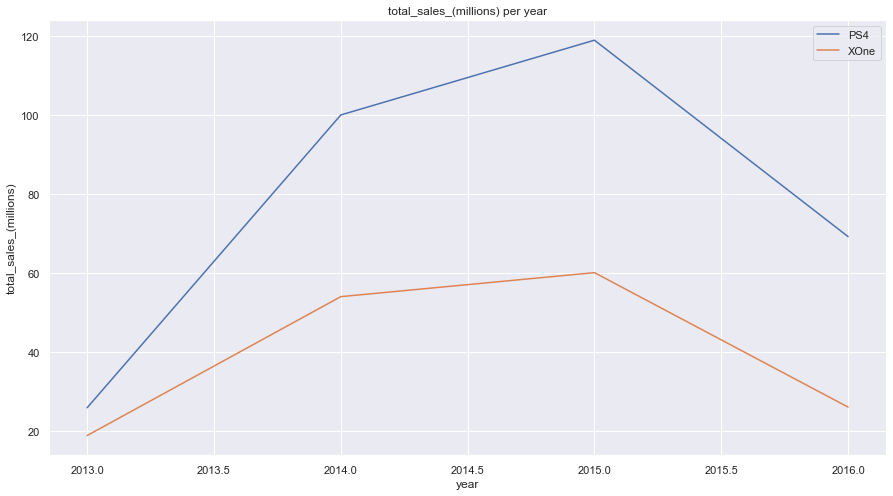

In [26]:
for platform in ['PS4', 'XOne']:
    t = df_2013_2016[df_2013_2016['platform'] == platform]
    sns.lineplot(data=t, x='year_of_release', y='sum', label=platform)

plt.legend(loc='best')
plt.title('total_sales_(millions) per year')
plt.xlabel('year')
plt.ylabel('total_sales_(millions)')
plt.show()

**Размах количества продаж игр на потенциально прибыльных платформах**

Посмотрим, как распределяются суммарные продажи игр на платформах. Для этого построим "ящики с усами".

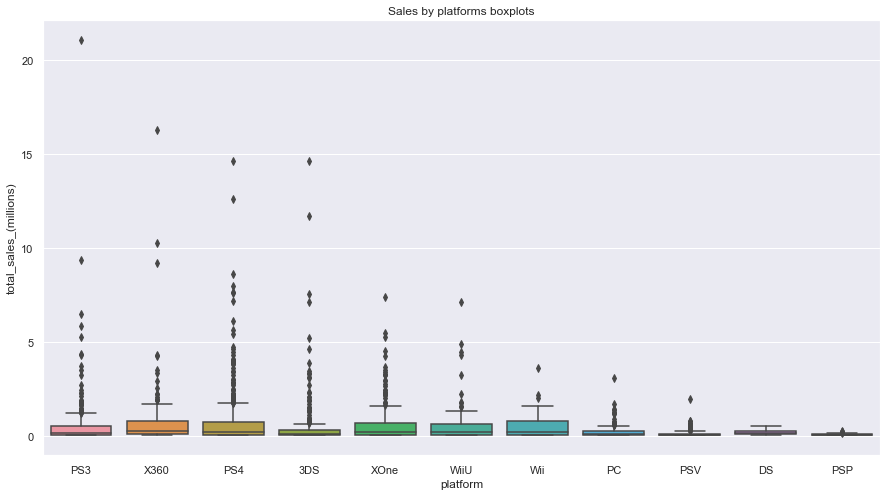

In [27]:
ax = sns.boxplot(x="platform", y="total_sales_(millions)", data=df[df['year_of_release'].between(2013,2016)])

plt.title('Sales by platforms boxplots')
plt.ylabel('total_sales_(millions)')
plt.show()

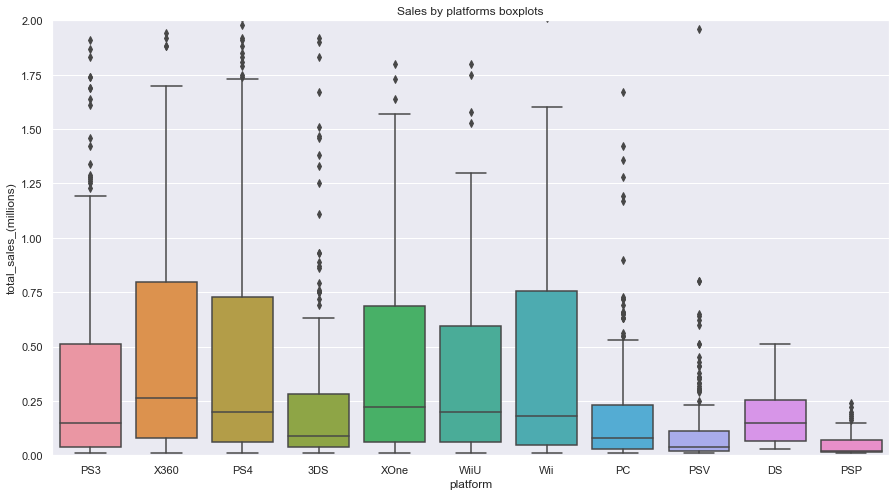

In [28]:
ax = sns.boxplot(x="platform", y="total_sales_(millions)", data=df[df['year_of_release'].between(2013,2016)])

plt.ylim(0, 2)
plt.title('Sales by platforms boxplots')
plt.ylabel('total_sales_(millions)')
plt.show()

- На платформах PS3, X360, PS4 и 3DS есть довольно много игр, суммарные продажи которых в разы превышают средние продажи по платформе. Сильнее всех этот эффект выражен у платформы PS3;
- Для оценки среднего количества продаж для каждой платформы лучше использовать медиану, а не среднее арифметическое;
- В среднем наибольшие продажи у игр на платформах X360, PS4, XOne, WiiU и Wii; 
- Продажи большинства игр на каждой платформе составляют не больше 800 тысяч.

**Влияние отзывов пользователей и критиков на продажи**

Сделаем выборку, соответствующую рассматриваемому нами актуальному периоду:

In [29]:
df_2013_2016 = df[df['year_of_release'].between(2013,2016)]

Выберем платформу для исследования. Предпочтительной будет та, у которой большое количество суммарных продаж и на которой сделано большое количество игр

In [30]:
df_2013_2016.groupby('platform')\
    .agg({'name': 'count', 'total_sales_(millions)': 'sum'})\
    .reset_index()\
    .rename(columns={'name':'games_count'})\
    .sort_values(['total_sales_(millions)', 'games_count'], ascending=[False, False])\
    .head()

,platform,games_count,total_sales_(millions)
4,PS4,392,314.14
3,PS3,345,181.43
10,XOne,247,159.32
0,3DS,303,143.25
9,X360,186,136.80


Выберем платформу PS4 - для нее сделана 392 игры, суммарные продажи которых составили 314,14 млн.

Посмотрим: видна ли линейная зависимость между оценкой пользователей и суммарными продажами.

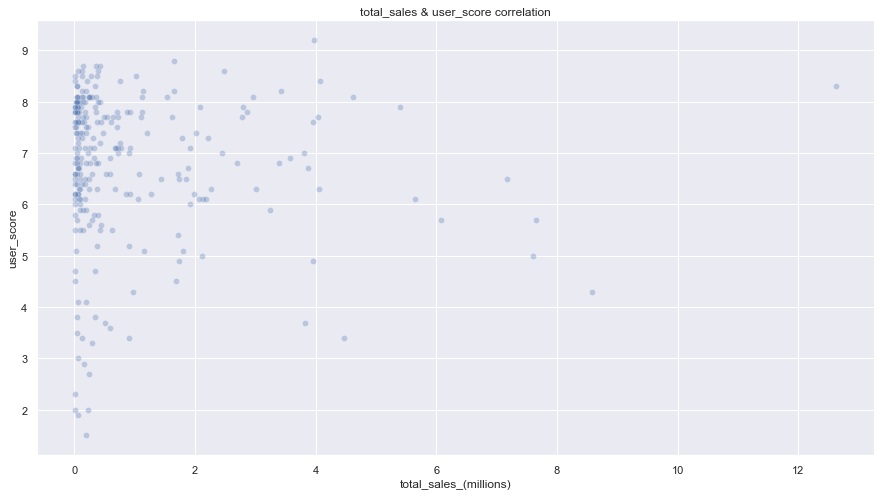

In [31]:
ax = sns.scatterplot(data=df_2013_2016[df_2013_2016['platform'] == 'PS4'], x='total_sales_(millions)', y='user_score', alpha=0.3)
plt.title('total_sales & user_score correlation')
plt.show()

Четкой линейной взаимосвязи между суммарными продажами и оценками пользователей не прослеживается. Считать коэффициент корреляции в таком случае не имеет смысла.

Посмотрим, есть ли взаимосвязь между оценками критиков и суммарными продажами.

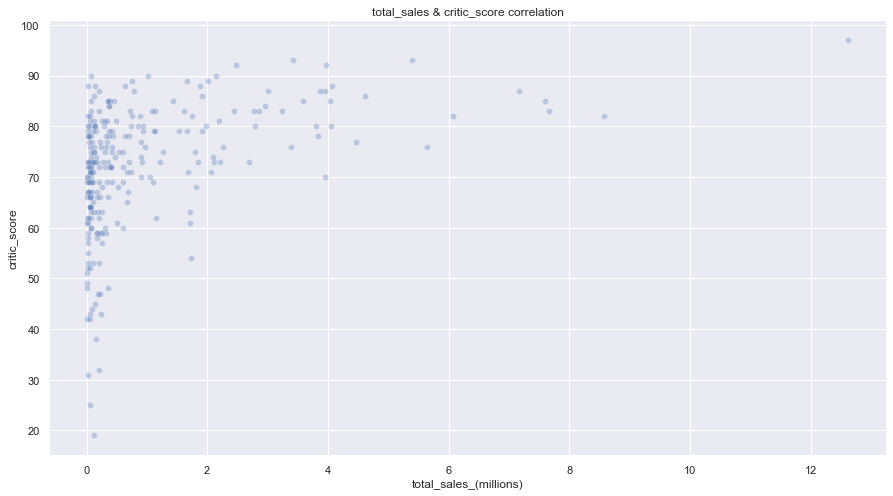

In [32]:
ax = sns.scatterplot(data=df_2013_2016[df_2013_2016['platform'] == 'PS4'], x='total_sales_(millions)', y='critic_score', alpha=0.3)
plt.title('total_sales & critic_score correlation')
plt.show()

Между продажами и оценками критиков положительная взаимосвязь уже прослеживается: чем выше оценки, тем больше в среднем продажи. Однако линейной эту взаимосвязь, смотря на график, назвать нельзя. Тем не менее, попробуем посчитать коэффициент корреляции.

In [33]:
t = df_2013_2016[(df_2013_2016['no_critic_score'] == False) & (df_2013_2016['platform'] == 'PS4')]
round((t['critic_score']*1000000).astype('int').corr(t['total_sales_(millions)']),2)

0.41

Значение коэффициента корреляции подтвержает наше предположение - линейной взаимосвязи почти нет.

Для проверки линейной взаимосвязи суммарных продаж и оценок критиков по каждой платформе напишем функцию. На вход она будет принимать исходный датафрейм, а возвращать - коэффициенты корреляции. 

In [34]:
def calc_correlation(data):
    result_df = pd.DataFrame(columns=['platform', 'critic_x_sales'])
    
    for platform in data['platform'].unique():
        new_row = dict()
        new_row['platform'] = platform
        subset = data[data['platform'] == platform]
        
        if (len(subset) == subset['no_critic_score'].sum() 
                or len(subset) - subset['no_critic_score'].sum() < 2):
            new_row['critic_x_sales'] = 'no_info'
        else:
            subset = subset[-subset['critic_score'].isna()]
            critic_sales_corr = (subset['critic_score']*1000000).astype('int').corr(subset['total_sales_(millions)'])
            new_row['critic_x_sales'] = critic_sales_corr
        
        result_df = result_df.append(new_row, ignore_index=True)
    return result_df

In [35]:
print(calc_correlation(df_2013_2016))

   platform critic_x_sales
0       PS3       0.334285
1      X360       0.350345
2       PS4       0.406568
3       3DS       0.357057
4      XOne       0.416998
5      WiiU       0.376415
6       Wii        no_info
7        PC        0.19603
8       PSV       0.254742
9        DS        no_info
10      PSP        no_info


no_info здесь обозначает, что у платформы нет оценок критиков совсем или их меньше двух, что делает невозможным расчет коэффициента корреляции.

Как видно из значений коэффициентов корреляции, сильной линейной зависимости суммарных продаж от оценок критиков не наблюдается ни по одной платформе. 

Наибольшие значения коэффициентов корреляции наблюдаются между суммарными продажами и оценками критиков у платформ PS4 и XOne. График рассеяния у первой мы уже смотрели - посмотрим, как он выглядит у второй.

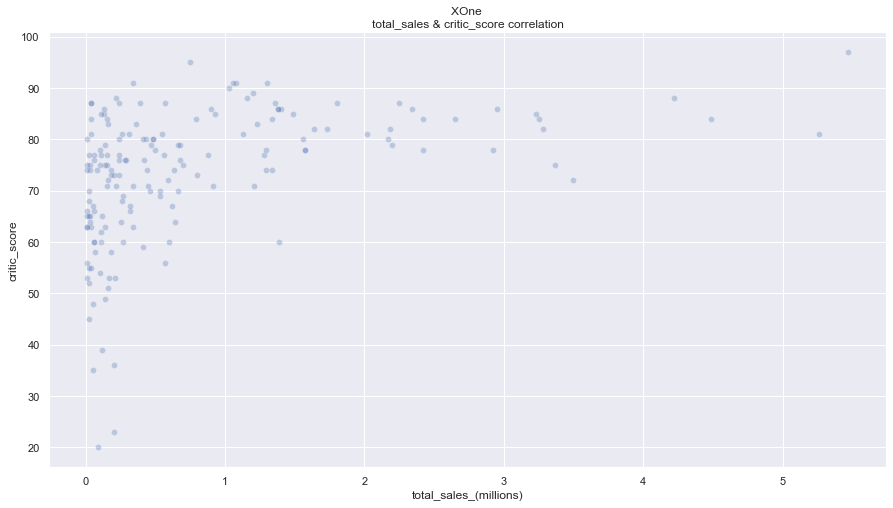

In [36]:
ax = sns.scatterplot(data=df_2013_2016[df_2013_2016['platform'] == 'XOne'], x='total_sales_(millions)', y='critic_score', alpha=0.3)
plt.title('XOne \ntotal_sales & critic_score correlation')
plt.show()

График напоминает тот, что мы видели для платформы PS4: при высоких оценках критиков меньше шанс получить маленькие продажи. Но строгой линейной зависимости визуально по-прежнему не прослеживается.

In [37]:
df_2013_2016[df_2013_2016['platform'].isin(['DS', 'PSP'])].groupby('platform')['critic_score'].count()

platform
DS     0
PSP    1
Name: critic_score, dtype: int64

**Распределение игр по жанрам**

In [38]:
df_2013_2016[df_2013_2016['genre'] != 'unknown'].groupby('genre')['total_sales_(millions)']\
    .agg(['count', 'mean', 'median'])\
    .sort_values(by='median')\
    .reset_index()

,genre,count,mean,median
0,Adventure,245,0.096490,0.030
1,Puzzle,17,0.186471,0.060
2,Strategy,56,0.180000,0.080
3,Misc,155,0.405290,0.100
4,Simulation,62,0.350968,0.100
5,Action,766,0.420196,0.110
6,Racing,85,0.469294,0.120
7,Fighting,80,0.441375,0.125
8,Role-Playing,292,0.499623,0.125
9,Platform,74,0.576081,0.225


Среднее арифметическое по всем продажам сильно отличается от медианы - это еще раз подверждает то, что у отдельных игр продажи в разы превышают большинство продаж других игр.

Количество игр в каждом жанре, кроме Puzzle, достаточное, чтобы взять медиану по количеству продаж для оценки средней прибыльности.

ТОП-3 жанра по продажам: Shooter, Sports и Platform.

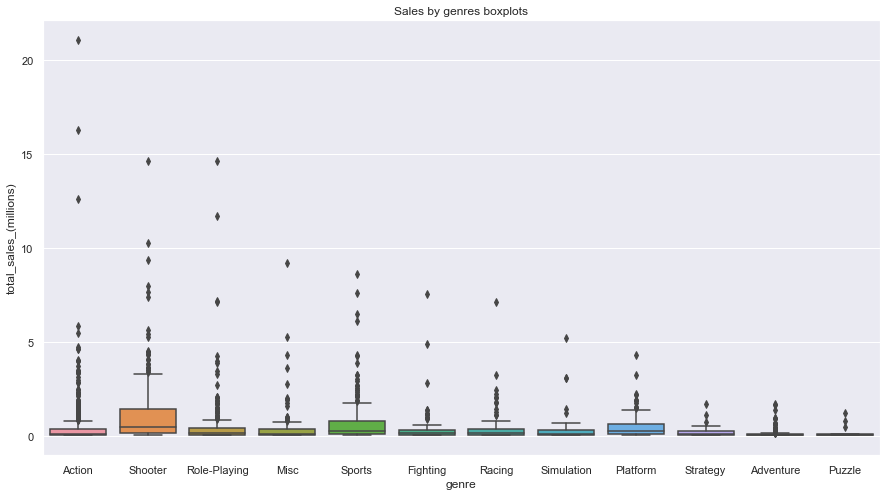

In [39]:
ax = sns.boxplot(x="genre", y="total_sales_(millions)", data=df_2013_2016)

plt.title('Sales by genres boxplots')
plt.ylabel('total_sales_(millions)')
plt.show()

Наибольший рахмах у Shooter, а судя по выбросам, лидер по самым большим единичным продажам - Action. 

Посмотрим графики подробнее, ограничив верхний предел 2,5 млн.

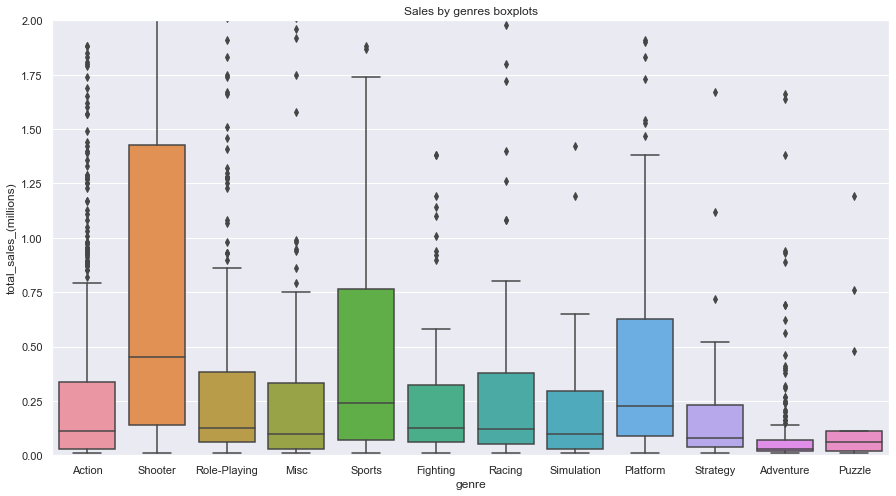

In [40]:
ax = sns.boxplot(x="genre", y="total_sales_(millions)", data=df_2013_2016)

plt.ylim(0,2)
plt.title('Sales by genres boxplots')
plt.ylabel('total_sales_(millions)')
plt.show()

Хорошая иллюстрация того, что Shooter - лидер по среднему количеству продаж. Да и вообще большинство игр в этом жанре продается лучше, чем в остальных. 

## Портреты пользователей по регионам

**Портрет пользователя в Северной Америке**

Посмотрим, какие платформы были наиболее популярны в 2013-2016 годах. Так как аналогичную операцию будем позже выполнять и для дургих регионов, напишем функцию.

In [41]:
def top_platforms(df, region):
    region_sales = region + '_sales_(millions)'
    return (df[df['year_of_release'].between(2013,2016)]\
                .groupby('platform')\
                .agg({region_sales: 'sum', 'name': 'count'})\
                .rename(columns={region_sales:'total_sales_(millions)', 'name': 'total_games'})\
                .sort_values(by='total_sales_(millions)', ascending=False)\
                .reset_index())

top_platforms(df, 'na')

,platform,total_sales_(millions),total_games
0,PS4,108.74,392
1,XOne,93.12,247
2,X360,81.66,186
3,PS3,63.50,345
4,3DS,38.20,303
5,WiiU,29.21,115
6,PC,11.11,189
7,Wii,6.56,23
8,PSV,5.04,358
9,DS,0.57,8


ТОП-5 платформ по продажам в Северной Америке за 2013-2016 годы:
- PS4;
- XOne;
- X360;
- PS3;
- 3DS.


Стоит отметить, что по количеству игр платформы XOne и X360 сильно отстают от PS4 и PS3. Однако на количестве продаж в этих платформах этот факт почти не отражается: PS3 они и вовсе обгоняют.

Посмотрим, какие жанры были наиболее популярны в 2013-2016 годах. Так как аналогичную операцию будем позже выполнять и для дургих регионов, напишем функцию.

In [42]:
def top_genres(df, region):
    region_sales = region + '_sales_(millions)'
    return (df[df['year_of_release'].between(2013,2016)]\
                .groupby('genre')\
                .agg({region_sales: 'sum', 'name': 'count'})\
                .rename(columns={region_sales:'total_sales_(millions)', 'name': 'total_games'})\
                .sort_values(by='total_sales_(millions)', ascending=False)\
                .reset_index())

top_genres(df, 'na')

,genre,total_sales_(millions),total_games
0,Action,126.05,766
1,Shooter,109.74,187
2,Sports,65.27,214
3,Role-Playing,46.40,292
4,Misc,27.49,155
5,Platform,18.14,74
6,Fighting,15.55,80
7,Racing,12.96,85
8,Adventure,7.14,245
9,Simulation,4.86,62


ТОП-5 жанров по продажам в Северной Америке:
- Action;
- Shooter;
- Sports;
- Role-Playing;
- Misc.

Отметим, что лидер жанров в Северной Америке - Action - сильно опережает остальных и по количеству продаж, и по количеству игр.

Также интересная ситуация в жанре Shooter: количество игр в этом жанре относительно невелико, однако они приносят достаточно продаж, чтобы шутеры были на втором месте в рейтинге жанров.

Посмотрим, как влиял возрастной рейтинг на продажи с 2013 по 2016 год. Для повторения этой операции для других регионов сразу напишем функцию.

In [43]:
def top_ratings(df, region):
    region_sales = region + '_sales_(millions)'
    return (df[df['year_of_release'].between(2013,2016)]\
                .groupby('rating')\
                .agg({region_sales: 'sum', 'name': 'count'})\
                .rename(columns={region_sales:'total_sales_(millions)', 'name': 'total_games'})\
                .sort_values(by='total_sales_(millions)', ascending=False)\
                .reset_index())

top_ratings(df, 'na')

,rating,total_sales_(millions),total_games
0,M,165.21,369
1,no_rating,89.42,977
2,E,79.05,302
3,E10+,54.24,252
4,T,49.79,333


Больше всего игр, проданных в Северной Америке за 2013-2016 годы, было отмечено рейтингом M (для возраста 17+).

На втором месте по продажам игры, у которых нет рейтинг. Это говорит о том, что они были выпущены не в США и не в Канаде. В Северной Америке играют не только в свои отечественные игры)

Стоит отметить, что большие продажи игр без возрастного рейтинга были обеспечены самым большим количеством наименований игр в этой группе.

*Выводы для Северной Америки*

- Самые популярные платформы: PS4, X360 и XOne; 
- Самый популярный жанр - Action. Однако по удельным продажам на одну игру лучший жанр - Shooter;
- В среднем игры с возрастным рейтингом "17+" продаются лучше остальных.

**Портрет пользователя в Европе**

Посмотрим, какие платформы были наиболее популярны в 2013-2016 годах.

In [44]:
top_platforms(df, 'eu')

,platform,total_sales_(millions),total_games
0,PS4,141.09,392
1,PS3,67.81,345
2,XOne,51.59,247
3,X360,42.52,186
4,3DS,30.96,303
5,PC,25.36,189
6,WiiU,19.85,115
7,PSV,6.10,358
8,Wii,5.93,23
9,DS,0.85,8


ТОП-5 платформ по продажам в Европе за 2013-2016 годы:
- PS4;
- PS3;
- XOne;
- X360;
- 3DS.

Состав полностью идентичен тому, что наблюдалось в Северной Америке. Только PS3 поднялась с 4 на 2 место, сместив XOne и X360.

Посмотрим, какие жанры были наиболее популярны в 2013-2016 годах.

In [45]:
top_genres(df, 'eu')

,genre,total_sales_(millions),total_games
0,Action,118.13,766
1,Shooter,87.86,187
2,Sports,60.52,214
3,Role-Playing,36.97,292
4,Racing,20.19,85
5,Misc,20.04,155
6,Platform,15.58,74
7,Simulation,10.92,62
8,Fighting,8.55,80
9,Adventure,8.25,245


ТОП-5 жанров по продажам в Европе:
- Action;
- Shooter;
- Sports;
- Role-Playing;
- Racing и Misc.

Action, как и в Америке, опережает остальных и по количеству продаж, и по количеству игр. 

Максимальное удельное количество продаж на одну игру в жанре Shooter.

В ТОП-5 добавился жанр Racing - игр в нем в 2 раза меньше, чем в жанре Misc, но продаж они обеспечили больше.

Посмотрим, как продавались игры с разным возрастным рейтингом.

In [46]:
top_ratings(df, 'eu')

,rating,total_sales_(millions),total_games
0,M,145.32,369
1,E,83.36,302
2,no_rating,78.91,977
3,E10+,42.69,252
4,T,41.95,333


Наибольшее количество наименований игр с отсутствием возрастного рейтинга. Но наибольшее количество продаж игр с рейтингом "17+".

И то, и другое очень похоже на тенденции в Северной Америке

*Выводы для Европы*

- Самые популярные платформы: PS4, PS3, XOne; 
- Самый популярный жанр - Action. Однако по удельным продажам на одну игру, как и в Северной Америке, лучший жанр - Shooter;
- В среднем игры с возрастным рейтингом "17+" продаются лучше остальных.

**Портрет пользователя в Японии**

Посмотрим, какие платформы были наиболее популярны в 2013-2016 годах.

In [47]:
top_platforms(df, 'jp')

,platform,total_sales_(millions),total_games
0,3DS,67.81,303
1,PS3,23.35,345
2,PSV,18.59,358
3,PS4,15.96,392
4,WiiU,10.88,115
5,PSP,3.29,67
6,X360,0.51,186
7,XOne,0.34,247
8,Wii,0.05,23
9,DS,0.00,8


ТОП-5 платформ по продажам в Японии:
- 3DS;
- PS3;
- PSV;
- PS4;
- WiiU.

Рейтинг платформ в Японии сильно отличается от тех, что мы наблюдали в Северной Америке и Европе: на первом месте по продажам здесь платформа 3DS, которая была только на пятом в других регионах.

Однако на этой платформе минимальное количество игр из первых четырех платформ. Следовательно, удельное количество продаж на одну игру у этой платформы максимальное. 

Посмотрим, какие жанры были наиболее популярны в 2013-2016 годах.

In [48]:
top_genres(df, 'jp')

,genre,total_sales_(millions),total_games
0,Role-Playing,51.04,292
1,Action,40.49,766
2,Misc,9.20,155
3,Fighting,7.65,80
4,Shooter,6.61,187
5,Adventure,5.82,245
6,Sports,5.41,214
7,Platform,4.79,74
8,Simulation,4.52,62
9,Racing,2.30,85


ТОП-5 жанров по продажам в Японии:
- Role-Playing;
- Action;
- Misc;
- Fighting;
- Shooter.

Рейтинг жанров в Японии отличается от рейтингов в других регионах. Action по-прежнему в лидерах, но уже второй. На первом здесь - Role-Playing. Еще в рейтинг добавился жанр Fighting.

Также отметим, что популярного в Европе и Северной Америке жанра Shooter в Японии только пятый.

Максимальное удельное количество продаж на одну игру в жанре Role-Playing.

Посмотрим, как продавались игры с разным возрастным рейтингом в Японии.

In [49]:
top_ratings(df, 'jp')

,rating,total_sales_(millions),total_games
0,no_rating,85.05,977
1,T,20.59,333
2,E,15.14,302
3,M,14.11,369
4,E10+,5.89,252


Лидеры по продажам в Японии игры, у которых отсутствует возрастной рейтинг. Это говорит о том, что в Японии лучше всего продаются игры, выпущенные не в США и не в Канаде.

In [50]:
# Комментарий ревьюера
temp = df[df['year_of_release'].between(2008,2015)].copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


no_rating    2803
E            1757
T            1276
E10+          930
M             855
EC              6
RP              1
Name: rating, dtype: int64

*Выводы для Японии*  

- Самые популярные платформы: 3DS, PS3 и PSV. На платформе 3DS удельное количество продаж на одну игру в Японии - максимальное; 
- Самый популярный жанр - Role-Playing. И по удельным продажам на одну игру он тоже лучший;
- Игры, у которых отсутствует возрастной рейтинг, продаются лучше остальных. Это говорит главным образом о том, что в Японии популярны игры, выпущенные не в США и не в Канаде. 

Посмотрим на круговых диаграммах распределение игр по платформам, жанрам и возрастным категориям в разных регионах:

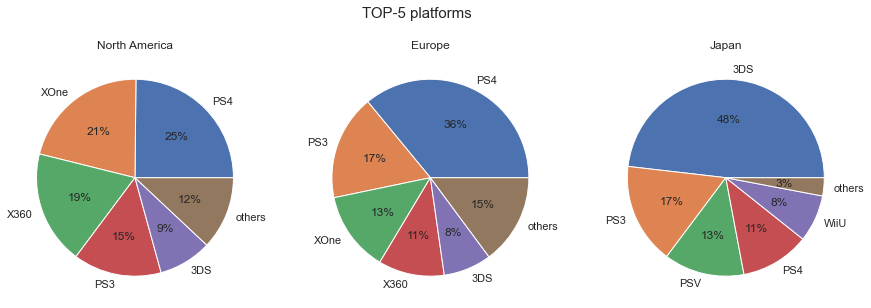

In [51]:
def top_5_platforms(df, region):
    platforms = top_platforms(df, region)
    return (platforms.head()\
                .append({'platform': 'others', 
                         'total_sales_(millions)': platforms.loc[5:, 'total_sales_(millions)'].sum(),
                         'total_games': platforms.loc[5:, 'total_games'].sum()
                        }, ignore_index=True))

na_platforms = top_5_platforms(df, 'na')

eu_platforms = top_5_platforms(df, 'eu')

jp_platforms = top_5_platforms(df, 'jp')

fig = plt.figure()
fig.suptitle('TOP-5 platforms', fontsize = 15, y=0.8)

plt.subplot(1, 3, 1)
plt.pie(na_platforms['total_sales_(millions)'], labels=na_platforms['platform'], autopct='%1.0f%%')
plt.title('North America')

plt.subplot(1, 3, 2)
plt.pie(eu_platforms['total_sales_(millions)'], labels=eu_platforms['platform'], autopct='%1.0f%%')
plt.title('Europe')

plt.subplot(1, 3, 3)
plt.pie(jp_platforms['total_sales_(millions)'], labels=jp_platforms['platform'], autopct='%1.0f%%')
plt.title('Japan')

plt.show();

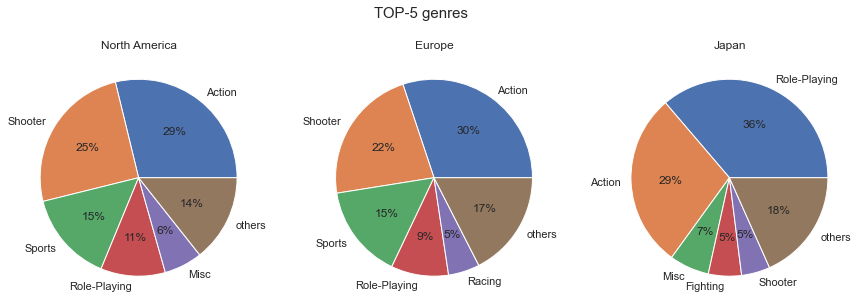

In [52]:
def top_5_genres(df, region):
    genres = top_genres(df, region)
    return (genres.head()\
                .append({'genre': 'others', 
                         'total_sales_(millions)': genres.loc[5:, 'total_sales_(millions)'].sum(),
                         'total_games': genres.loc[5:, 'total_games'].sum()
                        }, ignore_index=True))

na_genres = top_5_genres(df, 'na')

eu_genres = top_5_genres(df, 'eu')

jp_genres = top_5_genres(df, 'jp')

fig = plt.figure()

plt.subplot(1, 3, 1)
plt.pie(na_genres['total_sales_(millions)'], labels=na_genres['genre'], autopct='%1.f%%')
plt.title('North America')

plt.subplot(1, 3, 2)
plt.pie(eu_genres['total_sales_(millions)'], labels=eu_genres['genre'], autopct='%1.f%%')
plt.title('Europe')

plt.subplot(1, 3, 3)
plt.pie(jp_genres['total_sales_(millions)'], labels=jp_genres['genre'], autopct='%1.f%%')
plt.title('Japan')

fig.suptitle('TOP-5 genres', fontsize = 15, y=0.8)

plt.show();

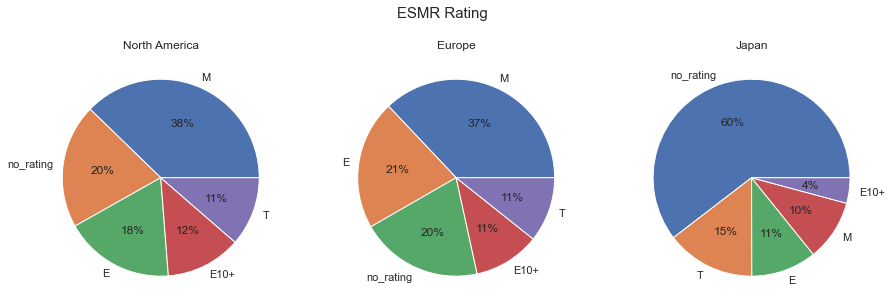

In [53]:
na_ratings = top_ratings(df, 'na')

eu_ratings = top_ratings(df, 'eu')

jp_ratings = top_ratings(df, 'jp')

fig = plt.figure()

plt.subplot(1, 3, 1)
plt.pie(na_ratings['total_sales_(millions)'], labels=na_ratings['rating'], autopct='%1.f%%')
plt.title('North America')

plt.subplot(1, 3, 2)
plt.pie(eu_ratings['total_sales_(millions)'], labels=eu_ratings['rating'], autopct='%1.f%%')
plt.title('Europe')

plt.subplot(1, 3, 3)
plt.pie(jp_ratings['total_sales_(millions)'], labels=jp_ratings['rating'], autopct='%1.f%%')
plt.title('Japan')

fig.suptitle('ESMR Rating', fontsize = 15, y=0.8)

plt.show();

## Проверка гипотез

**Сравнение средних пользовательских рейтингов платформ Xbox One и PC**

Сформулируем нулевую и альтернативную гипотезы:
- H0: средние пользовательские рейтинги платформ Xbox One и PC равны
- H1: средние пользовательские рейтинги платформ Xbox One и PC не равны

Уровень значимости для того, чтобы отвергнуть нулевую гипотезу, примем равным α = 0,05.

In [54]:
# сформируем выбоку оценок для платформы Xbox One
XOne_rating =  df_2013_2016[(df_2013_2016['platform'] == 'XOne') & (-df_2013_2016['user_score'].isna())]['user_score']

# сформируем выбоку оценок для платформы PC
PC_rating = df_2013_2016[(df_2013_2016['platform'] == 'PC') & (-df_2013_2016['user_score'].isna())]['user_score']

# посмотрим равны ли дисперсии выборок
print(XOne_rating.var(), PC_rating.var(), sep='\n')

1.9069968429360702
3.035892752408884


Дисперсии отличаются, поэтому параметр equal_var поставим False.

In [55]:
results = st.ttest_ind(XOne_rating, PC_rating, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < 0.05:
    print('Нулевая гипотеза должна быть отвергнута')
else:
    print('Нулевая гипотеза верна')

p-значение:  0.14759594013430463
Нулевая гипотеза верна


*Вывод:* статистический тест показал, что вероятность получить значения выборок, как у нас, или еще более экстремальные при условии, что нулевая гипотеза верна, достаточно велика. Это позволяет нам не отбрасывать гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC равны.

**Сравнение средних пользовательских рейтингов жанров Action и Sports**

Сформулируем нулевые и альтернативную гипотезы:
- H0: средние пользовательские рейтинги жанров Action и Sports равны
- H1: средние пользовательские рейтинги жанров Action и Sports не равны

Уровень значимости для того, чтобы отвергнуть нулевую гипотезу, примем равным α = 0,05.

In [56]:
# сформируем выбоку оценок для жанра Action
Action_rating =  df_2013_2016[(df_2013_2016['genre'] == 'Action') & (-df_2013_2016['user_score'].isna())]['user_score']

# сформируем выбоку оценок для жанра Sports
Sports_rating = df_2013_2016[(df_2013_2016['genre'] == 'Sports') & (-df_2013_2016['user_score'].isna())]['user_score']

# посмотрим равны ли дисперсии выборок
print(Action_rating.var(), Sports_rating.var(), sep='\n')

1.76936090424827
3.1806128144654062


Дисперсии отличаются, поэтому параметр equal_var поставим False.

In [57]:
results = st.ttest_ind(Action_rating, Sports_rating, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < 0.05:
    print('Нулевая гипотеза должна быть отвергнута')
else:
    print('Нулевая гипотеза верна')

p-значение:  1.4460039700704315e-20
Нулевая гипотеза должна быть отвергнута


*Вывод:* статистический тест показал, что вероятность получить значения выборок, как у нас, или еще более экстремальные при условии, что нулевая гипотеза верна, крайне мала. Это позволяет нам отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports равны.

Посмотрим средние пользовательские рейтинги по платформам:

In [58]:
df_2013_2016[df_2013_2016['platform'].isin(['XOne', 'PC'])].groupby('platform')['user_score'].agg({'mean', 'median'})

,mean,median
platform,,
PC,6.269677,6.8
XOne,6.521429,6.8


Средние пользовательские оценки, действительно, очень близки, а медианные и вовсе равны. 
 
 Посмотрим средние пользовательские рейтинги по жанрам:

In [59]:
df_2013_2016[df_2013_2016['genre'].isin(['Action', 'Sports'])].groupby('genre')['user_score'].agg({'mean', 'median'})

,mean,median
genre,,
Action,6.837532,7.1
Sports,5.238125,5.5


А по жанрам пользовательские уже довольно сильно отличаются.

Нулевая гипотеза всегда более консервативна, поэтому в ней мы зафиксировали равенство средних оценок. Соответственно, в альтернативную гипотезу поместили случаи отсутвия разницы.

В обоих случаях мы использовали ttest_ind, так как проверяли равенство средних значений двух выборок, взятых из разных генеральных совокупностей.

Уровень значимости был выбран равным общепринятому значению α = 0.05, так как в нашем случае было нестрашно отвергнуть верную нулевую гипотезу и допустить отсутствие равенства средних пользовательских рейтингов. Однако даже если бы мы установили уровень значимости равным α = 0.01, в нашем случае результаты тестов бы не изменились.

## Общие выводы

*Тенденции:*
- Количество выпускаемых игр начало активно расти с 90-х годов. Достигло своего пика в 2008-2009 годах. В 2012 последовал довольно резки спад;
- Самой продаваемыми за период 1980-2015 были игры для платформы PS2;
- Период популярности одной платформы составляет 5-10 лет;
- В среднем старые платформы сменяются новыми каждые 5-8 лет;
- Сильной линейной зависимости суммарных продаж от оценок критиков или от оценок пользователей не наблюдается ни по одной платформе. Но при высоких оценках критиков шанс получить маленькие продажи все-таки меньше.

*Портреты пользователей по регионам:*
- Рейтинги самых популярных платформ в Северной Америке и Европе почти не отличаются. Лидер и там, и там - PS4. Также в ТОП-5 входят: PS3,  XOne, X360 и 3DS;
- Сильно отличается от них японский рейтинг платформ. Там лидер - 3DS. За ним идут PS3, PSV, PS4 и WiiU;
- Рейтинги жанров в Европе и в Северной Америке абсолютно идентичны. В лидерах - Action , Shooter и Sports. Причем Action опережает остальные жанры и по количеству продаж, и по количеству игр. А максимальное удельное количество продаж на одну игру в жанре Shooter;
- В Японии самые популярные жанры: Role-Playing, Action и Misc;
- В Северной Америке и Европе игры с возрастным рейтингом "17+" в среднем продаются лучше остальных;
- В Японии наиболее популярные игры не имеют рейтинга, что главным образом говорит о том, что они были выпущены не в США и не в Канаде.

*Немного прогнозов:*
- Как потенциально прибыльные выделим две платформы: PS4 и XOne. Обе появились в 2013 году и находятся в зоне роста продаж;
- Всего на платформе PS4 продавалось 392 игры за 2013-2015 годы. В среднем одна игра продается 200 тысяч раз;
- Всего на платформе XOne продавалось 247 игр за 2013-2015 годы. В среднем одна игра продается 220 тысяч раз;

*Проверка гипотез:*
- Гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC не была отвергнута;
- Гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports была отвергнута.

*Рекомендации:*

Логично предположить, что игры с хорошими оценками критиков и пользователей продаются лучше тех, у которых оценки хуже. Однако сильной корреляции между этими параметрами не наблюдается. Поэтому полагаться исключительно на отзывы будет ошибочно.


При планировании рекламного бюджета на 2017 год стоит обратить внимание:
- в Северной Америке и Европе: на игры в жанрах Action , Shooter и Sports с возрастным рейтингом "17+" на платформах PS4 и XOne;
- в Японии: на игры в жанрах Role-Playing, Action и Misc на платформах 3DS и PS3. На возрастной рейтинг здесь полагаться нельзя, потому что чаще продавались игры, у которых возрастной рейтинг отсутствовал.